# Phase II: Testing ROS with Several Models for Comparison


## I repeat the steps I took to prepare the dataset from my EDA

In [1]:
'''
*    Text Pre-Processing    *
'''
import pandas as pd
import nltk
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


'''
*    Plotting    *
'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator


'''
*    Training & Metrics    *
'''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle



'''
*    Model Selection    *
'''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
'''import'''
df = pd.read_csv('master_f.csv')
df.fillna(method = 'pad')


'''assigning labels and storing in variable to prepare for holdout creation'''
df_dep = df.loc[df['label'] == 0] 
df_ptsd = df.loc[df['label'] == 1]
df_cptsd = df.loc[df['label'] == 2] 
df_bpd = df.loc[df['label'] == 3]
df_bipolar = df.loc[df['label'] == 4] 
df_diss = df.loc[df['label'] == 5]


'''creating holdouts'''
df_dep_holdout = df_dep.iloc[:5]
df_ptsd_holdout = df_ptsd.iloc[:5]
df_cptsd_holdout = df_cptsd.iloc[:5]
df_bpd_holdout = df_bpd.iloc[:5]
df_bipolar_holdout = df_bipolar.iloc[:5]
df_diss_holdout = df_diss.iloc[:5]


'''re-defining variables with holdout documents ommitted'''
df_dep = df_dep.iloc[5:]
df_ptsd = df_ptsd.iloc[5:]
df_cptsd = df_cptsd.iloc[5:]
df_bpd = df_bpd.iloc[5:]
df_bipolar = df_bipolar.iloc[5:]
df_diss = df_diss.iloc[5:]


'''concat the pieces back together'''
df = pd.concat([df_dep, df_ptsd, df_cptsd, df_bpd, df_bipolar, df_diss])
df_holdout = pd.concat([df_dep_holdout, df_ptsd_holdout, df_cptsd_holdout, df_bpd_holdout, df_bipolar_holdout, df_diss_holdout])
df.dropna()

print(df.shape)
print(df.keys())

(9491, 2)
Index(['label', 'text'], dtype='object')


In [3]:
'''
# defining symbols/characters to remove
# set the stopword to 'english'
# define tokenizer & lemmatizer
'''
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;']")
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()




'''defining method for cleaning text input'''
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(x for x in text.split() if x not in STOPWORDS) # delete stopwors from text
    return text


'''defining lemmatizer'''
def word_lemmatizer(text):
    lem_text = [LEMMATIZER.lemmatize(x) for x in text]
    return lem_text  


'''applying pre-processing'''
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: TOKENIZER.tokenize(x))
df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))


df = df.dropna(how='any',axis=0)
df.shape

(9491, 2)

In [5]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(9491, 22482)


(9491,)

In [6]:
'''Random Over Sampling is a method that evens out the distribution of your classes by inflating the underrepresented classes.'''
ovs = RandomOverSampler(random_state=42)
X_res, y_res = ovs.fit_resample(X,y)


'''Random Under Sampling is the converse of ROS, where the overrepresented classes are reduced to match the underrepresented classes'''
ous = RandomUnderSampler(random_state=42)
X_res_b, y_res_b = ous.fit_resample(X,y)

# Random Over Sampling - put to the test

I specified several neighborhoods to compare performance. I raised the dimensionality to 6 because the number of unique classes I am examining is 6. Hopefully I retain more information this way and achieve better separation in the classes.

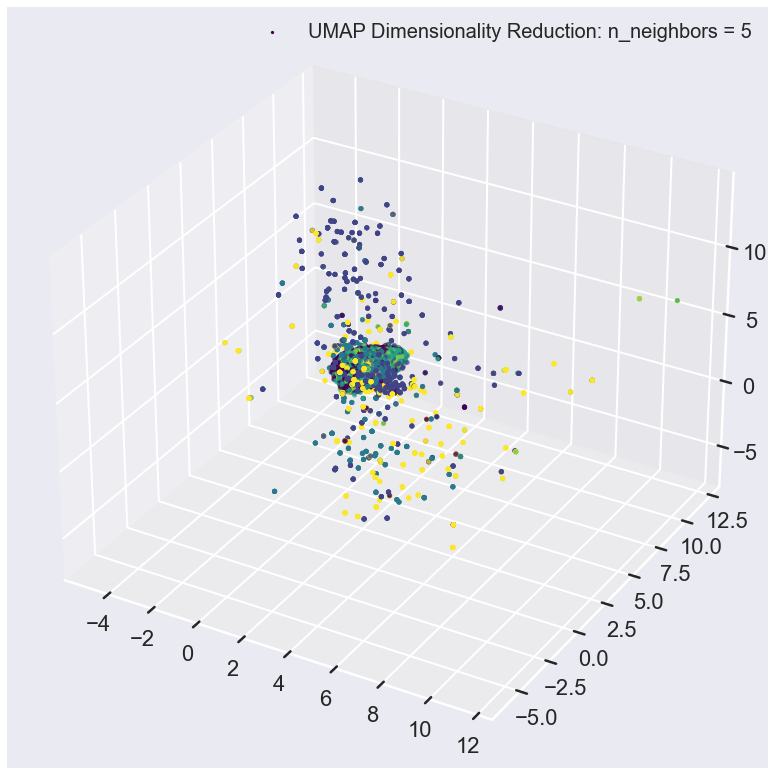

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.688204         0.68632     0.688724   
6           K Nearest Neighbor       0.637053        0.636008     0.637525   
3               Decsision Tree       0.594714         0.59414     0.594651   
4                     AdaBoost       0.408713        0.401678     0.409818   
7          Logistic Regression        0.28512        0.271136     0.286028   
5         Gaussian Naive Bayes       0.276309        0.256075     0.277031   
1  Stochastic Gradient Descent       0.209985        0.308281     0.206722   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
2  0.685908  
6   0.63568  
3  0.594171  
4  0.397177  
7  0.252506  
5  0.215597  
1  0.125615  
0  0.046596  


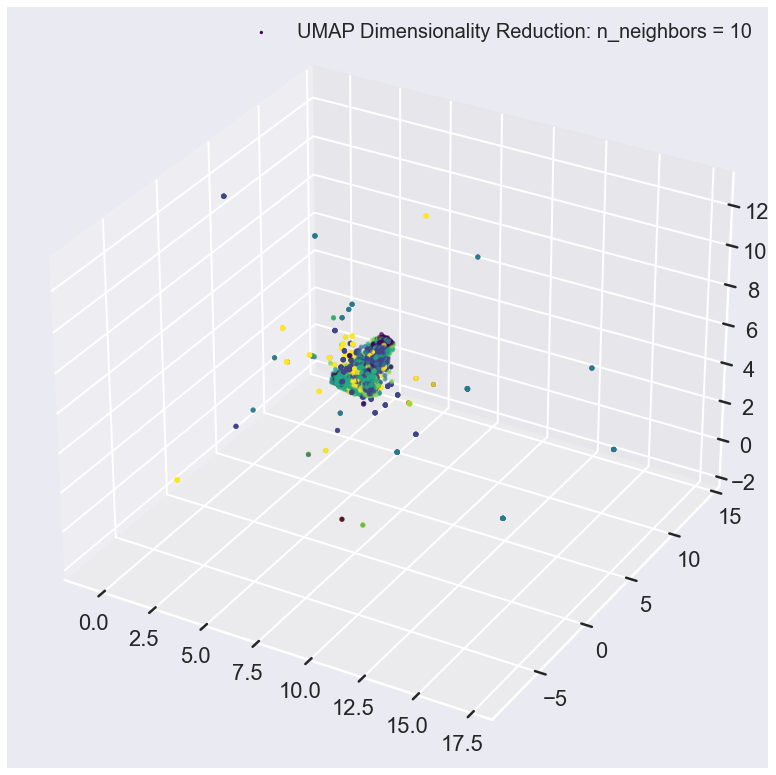

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.792462        0.793808     0.792737   
6           K Nearest Neighbor       0.776065        0.778729      0.77644   
3               Decsision Tree        0.68233        0.684329      0.68249   
4                     AdaBoost       0.452521        0.447867     0.452124   
7          Logistic Regression       0.343612        0.299016     0.344304   
5         Gaussian Naive Bayes       0.316446        0.296692     0.314758   
1  Stochastic Gradient Descent       0.215859         0.30694      0.21637   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
2  0.792924  
6  0.776481  
3  0.683103  
4  0.446083  
7  0.303318  
5  0.243745  
1  0.127505  
0  0.046596  


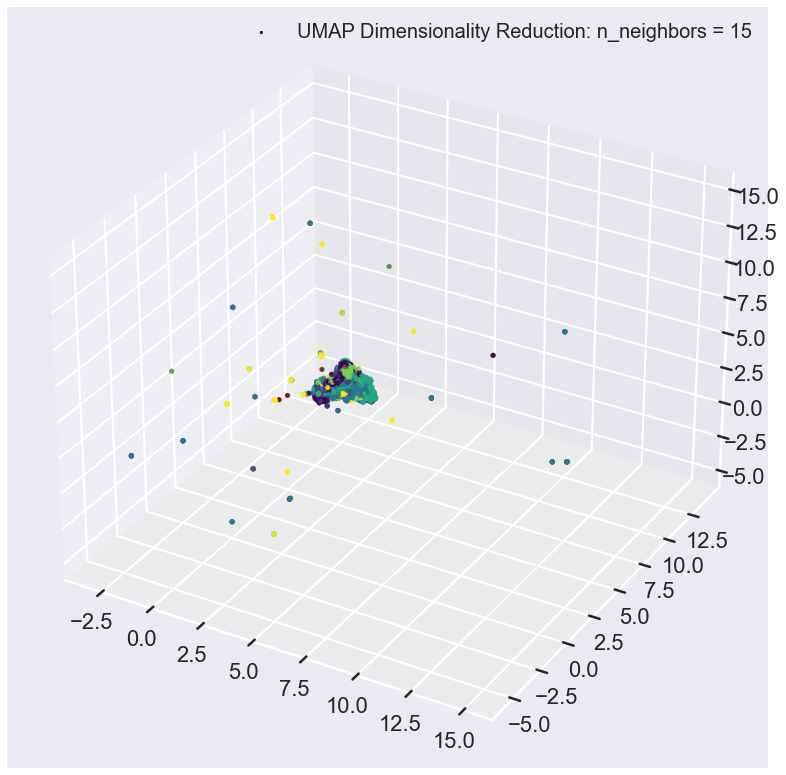

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.918502        0.918578     0.918511   
2                Random Forest       0.911894        0.911722     0.911851   
3               Decsision Tree       0.841165          0.8422     0.841457   
4                     AdaBoost       0.500979        0.503775     0.502631   
7          Logistic Regression       0.421439        0.391153     0.422488   
5         Gaussian Naive Bayes       0.239843          0.2255      0.23749   
1  Stochastic Gradient Descent       0.174743        0.195314     0.172123   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
6  0.918421  
2  0.911677  
3  0.841679  
4   0.49942  
7  0.395159  
5  0.174555  
1  0.059457  
0  0.046596  


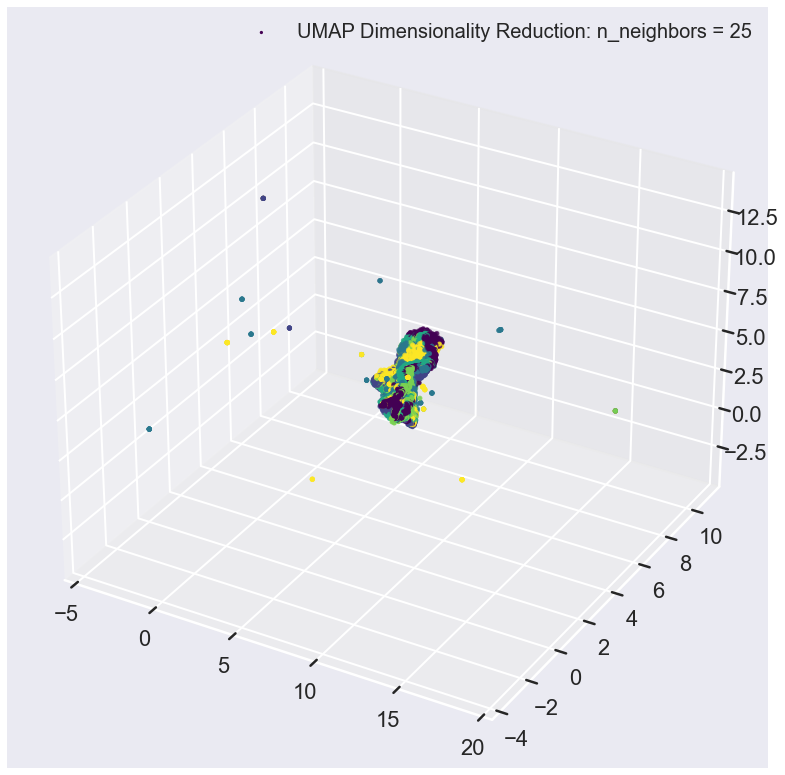

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.830396        0.830799     0.830482   
6           K Nearest Neighbor       0.828194        0.830051     0.828291   
3               Decsision Tree       0.745472          0.7466     0.745557   
4                     AdaBoost       0.388399        0.381353      0.38864   
7          Logistic Regression       0.329418        0.300426      0.33029   
5         Gaussian Naive Bayes        0.30837        0.328157      0.30967   
1  Stochastic Gradient Descent        0.26652        0.225978     0.261851   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
2  0.830205  
6  0.827493  
3   0.74575  
4  0.354314  
7  0.290843  
5  0.259466  
1  0.194453  
0  0.046596  


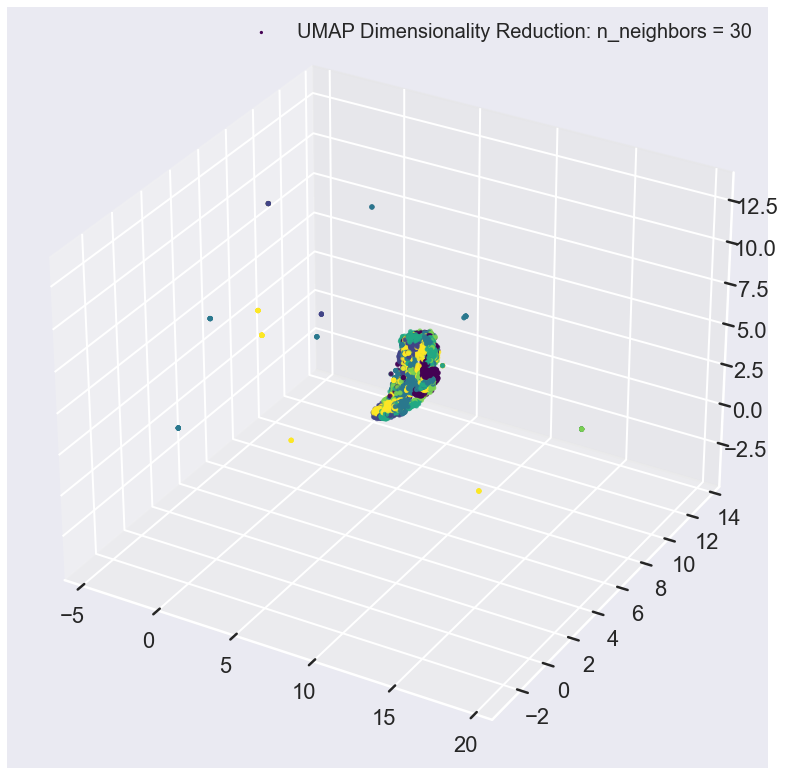

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.941752        0.941515     0.941545   
2                Random Forest       0.933186        0.933431     0.932909   
3               Decsision Tree        0.85952        0.859461     0.859381   
4                     AdaBoost       0.415321        0.439825     0.417475   
7          Logistic Regression       0.338718        0.334524      0.34032   
5         Gaussian Naive Bayes       0.298581        0.282236     0.299618   
1  Stochastic Gradient Descent       0.205825        0.276897       0.2062   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
6  0.941451  
2   0.93299  
3  0.859326  
4  0.409125  
7  0.302874  
5  0.214873  
1  0.109254  
0  0.046596  


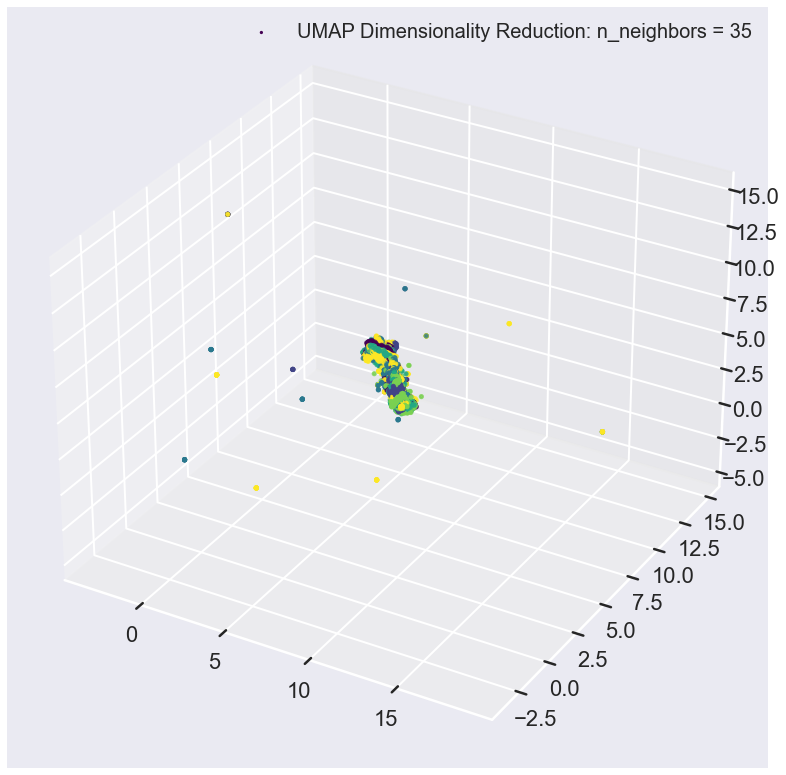

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.945668        0.945597     0.945691   
2                Random Forest       0.938081        0.938064     0.938169   
3               Decsision Tree       0.870534        0.870339     0.870783   
4                     AdaBoost       0.425844        0.418371     0.426827   
7          Logistic Regression        0.30372        0.248069     0.303673   
5         Gaussian Naive Bayes       0.309838        0.265093     0.312326   
1  Stochastic Gradient Descent       0.225649        0.266963     0.224014   
0                        Dummy       0.162506        0.027084     0.166667   

   f1_score  
6  0.945576  
2  0.937974  
3  0.870397  
4  0.416637  
7  0.249107  
5  0.227356  
1  0.125071  
0  0.046596  


In [7]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Results

I achieved the optimal result at n_neighbors = 35. I reset the data_umap variable below for further analysis.

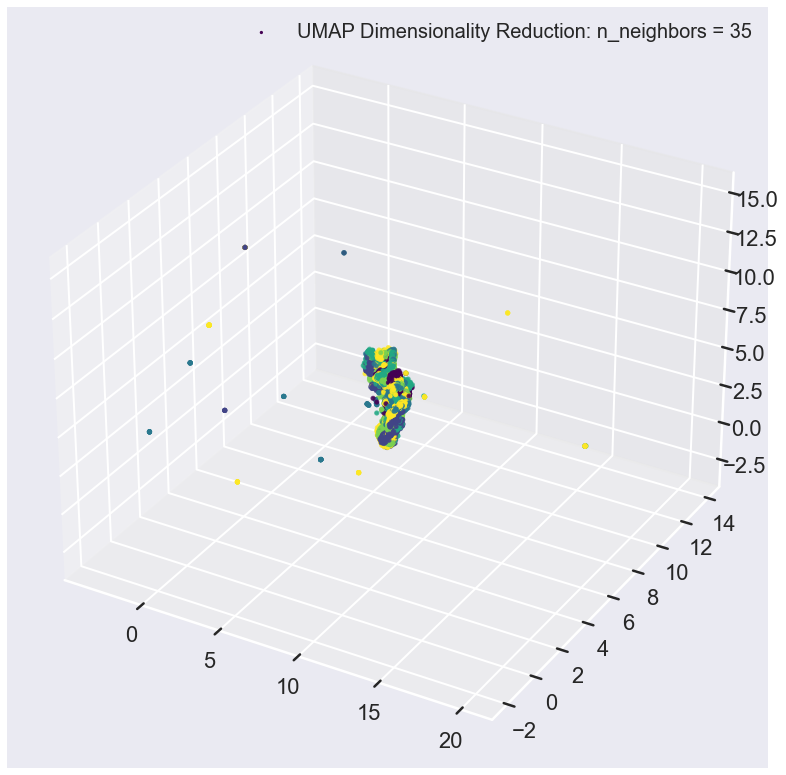

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Random Forest,0.907489,0.907277,0.907519,0.907302
3,K Nearest Neighbor,0.902349,0.901789,0.902373,0.901918
1,Decsision Tree,0.828439,0.828222,0.828559,0.82825
2,AdaBoost,0.381791,0.378325,0.383711,0.369106


In [8]:
fit = umap.UMAP(n_neighbors = 35,
                min_dist = .1,
                n_components = 6,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 35'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y_res, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



# KNN GridSearchCV - looking for the best parameters 

A cautionary tale, this takes a huge burden on the CPU. I used Google Colab's GPU acceleration for this portion, so please excuse the absence of an output for this cell.

In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res, y_res)

In [ ]:
KNN_best = gridsearch.best_params_
print(KNN_best)

In [9]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=7,
                                      p =2,
                                      weights='distance')

## Plotting the AUC/ROC Curves

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


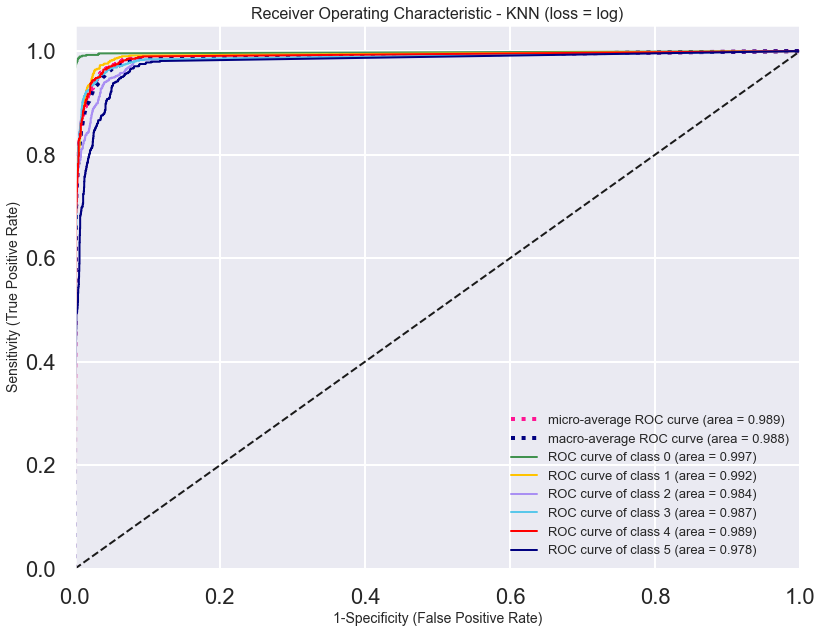

In [10]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix

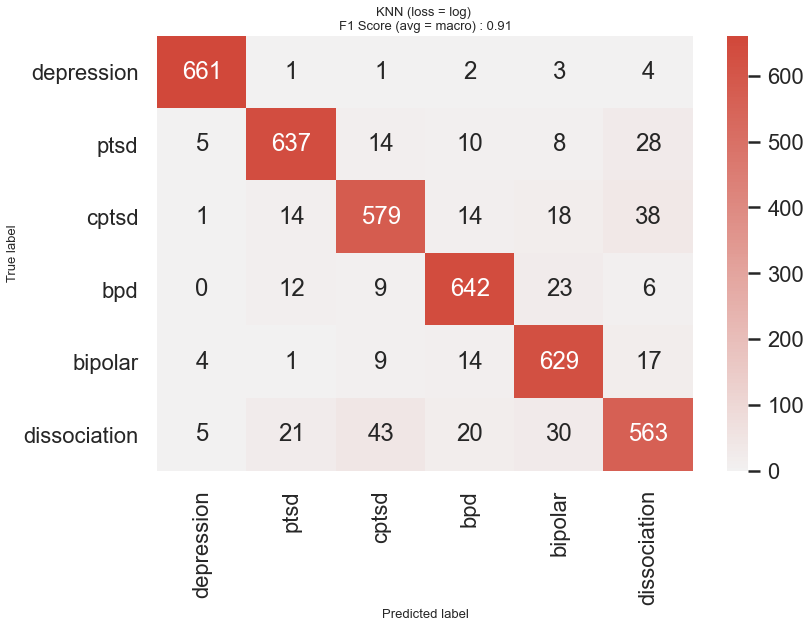

In [11]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_c, y_train_c)
y_pred = knn_best_model.predict(X_test_c)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_c, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_c, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


## Predicting Unseen Data

In [12]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.19      1.00      0.32         5
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.09      0.20      0.10        30
weighted avg       0.09      0.20      0.10        30



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,label,pred_knn,correct
0,Does anyone else have intrusive thoughts and t...,0,1,0
1,My agony has started when I came off antidepre...,0,1,0
2,Two weeks I've been taking Sertraline. Mood is...,0,1,0
3,"Hi,\nI honestly don't know what is wrong with ...",0,1,0
4,"Hi, am I the only one who doesn't like my own ...",0,1,0
2266,Hey guys\n\nAs mentioned in my previous questi...,1,1,1
2267,"Hello,\n\n\nFirst of all, sorry if this is in ...",1,1,1
2268,"I get triggered by the TV, at the moment there...",1,1,1
2269,"I'm in my 30s and have suffered from PTSD, shy...",1,1,1
2270,hey guys\n\nI hope all is well with you these ...,1,1,1


# Random Under Sampling - put to the test
Finally, we get to review the models' performance provided a RUS.


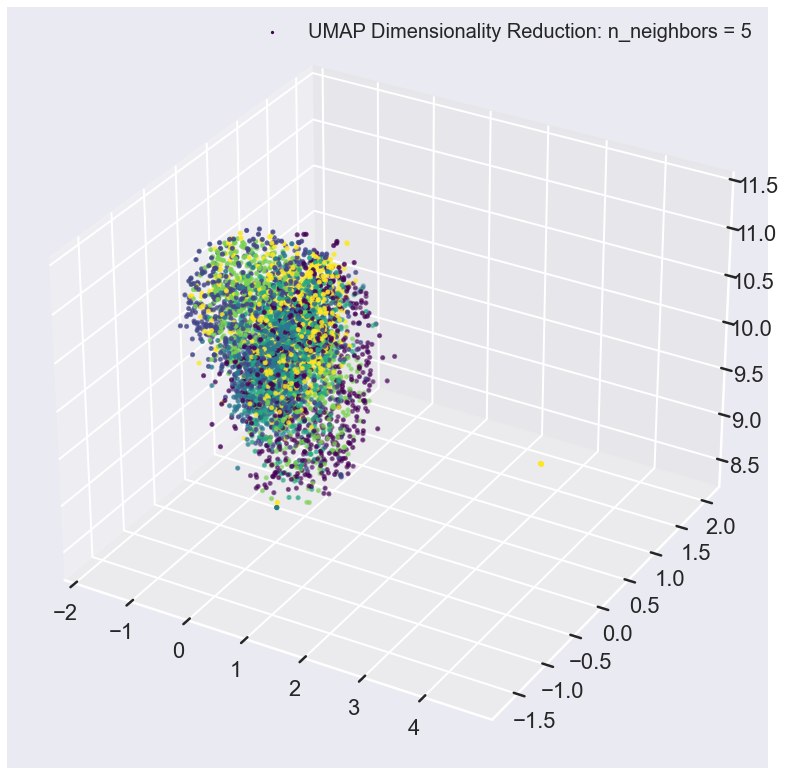

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.700437        0.701017     0.703091   
6           K Nearest Neighbor       0.678571        0.676795     0.681199   
3               Decsision Tree       0.548105        0.551313     0.549103   
4                     AdaBoost       0.459184        0.460382     0.462529   
5         Gaussian Naive Bayes       0.459913        0.446304     0.460887   
7          Logistic Regression       0.345481        0.338753     0.345276   
1  Stochastic Gradient Descent       0.217201        0.256833     0.215092   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
2  0.700979  
6  0.678112  
3  0.549947  
4  0.458316  
5  0.445417  
7  0.332154  
1  0.138359  
0  0.044248  


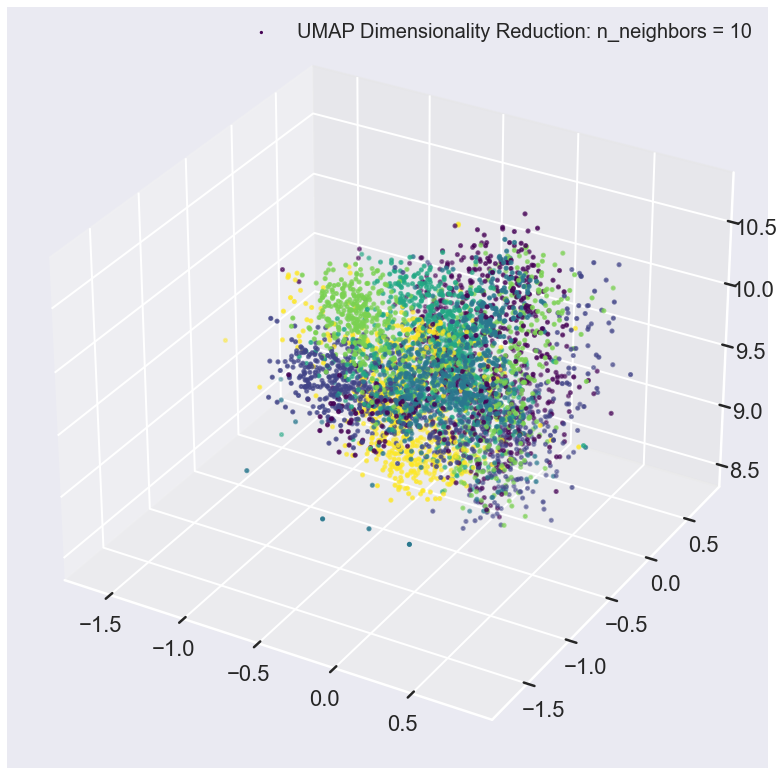

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.911808        0.913087     0.912511   
2                Random Forest       0.908163        0.908655      0.90871   
3               Decsision Tree       0.825802        0.827002     0.827004   
4                     AdaBoost       0.620991        0.624295     0.621774   
5         Gaussian Naive Bayes       0.610787        0.623336     0.612265   
7          Logistic Regression       0.488338        0.483164     0.491187   
1  Stochastic Gradient Descent       0.412536        0.356102     0.417046   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
6  0.911909  
2  0.908365  
3  0.826793  
4  0.618149  
5  0.608718  
7    0.4767  
1  0.304594  
0  0.044248  


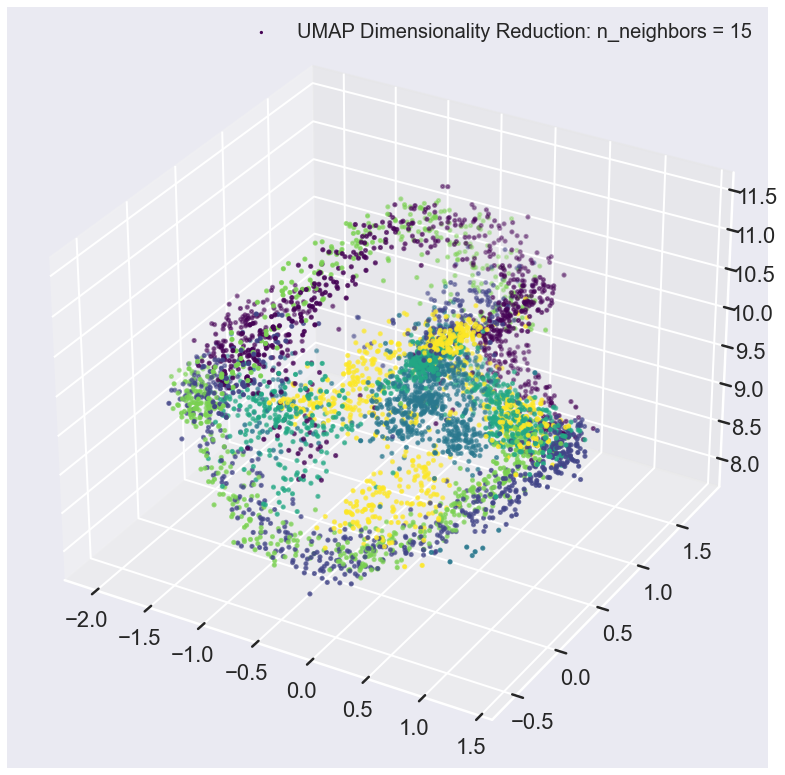

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor        0.87172          0.8724     0.872978   
2                Random Forest       0.852041        0.854447     0.853562   
3               Decsision Tree       0.760204        0.761163      0.76187   
4                     AdaBoost       0.513848        0.521501     0.517145   
5         Gaussian Naive Bayes       0.481778        0.470214     0.485356   
7          Logistic Regression       0.404519        0.401401     0.403732   
1  Stochastic Gradient Descent       0.190233        0.196734     0.189542   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
6  0.871798  
2   0.85289  
3  0.761136  
4   0.51454  
5  0.469465  
7   0.39071  
1  0.090469  
0  0.044248  


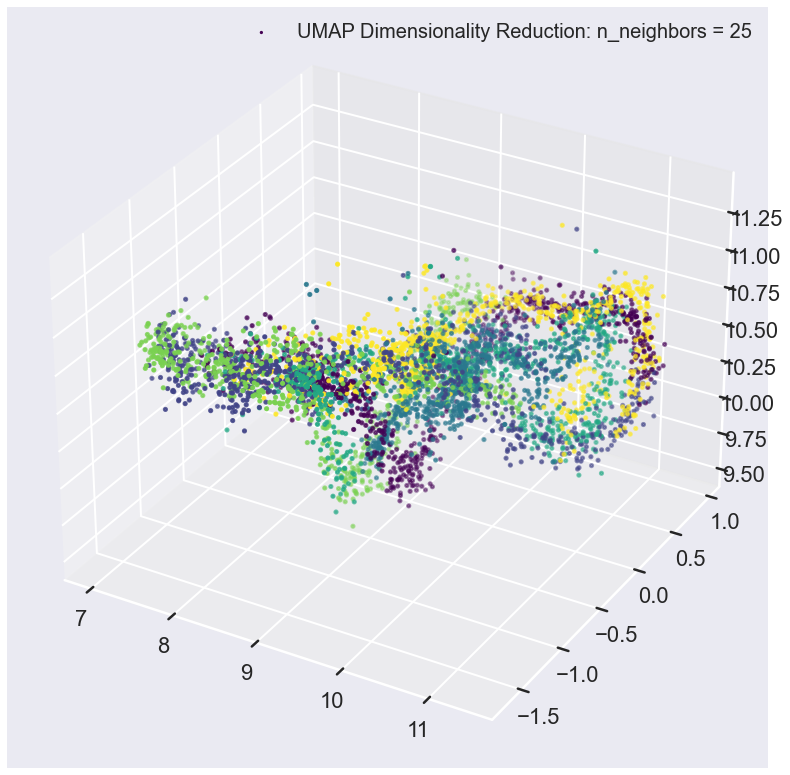

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.920554        0.921796     0.921127   
2                Random Forest       0.919096        0.919993     0.919505   
3               Decsision Tree       0.840379         0.84291     0.840346   
4                     AdaBoost        0.46137        0.461468     0.464788   
5         Gaussian Naive Bayes         0.4293        0.442744     0.432492   
7          Logistic Regression        0.40379        0.398574     0.405302   
1  Stochastic Gradient Descent       0.231778        0.307744      0.23284   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
6  0.920612  
2  0.919597  
3  0.841256  
4  0.460273  
5   0.42956  
7  0.395886  
1  0.148879  
0  0.044248  


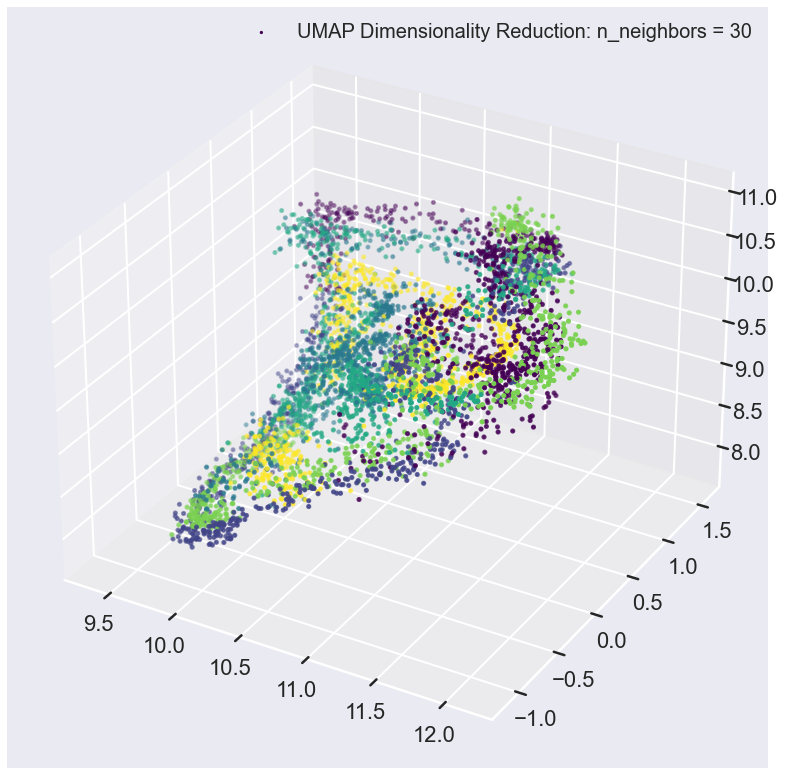

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.946793        0.946576     0.946773   
2                Random Forest        0.93586        0.935545     0.935726   
3               Decsision Tree       0.857872        0.857428     0.857766   
4                     AdaBoost       0.480321        0.467154     0.485666   
5         Gaussian Naive Bayes       0.470845        0.479925     0.472681   
7          Logistic Regression       0.376822        0.391916     0.375359   
1  Stochastic Gradient Descent       0.310496        0.223053     0.314134   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
6  0.946618  
2  0.935403  
3  0.857336  
4   0.46583  
5  0.463913  
7  0.372554  
1  0.245522  
0  0.044248  


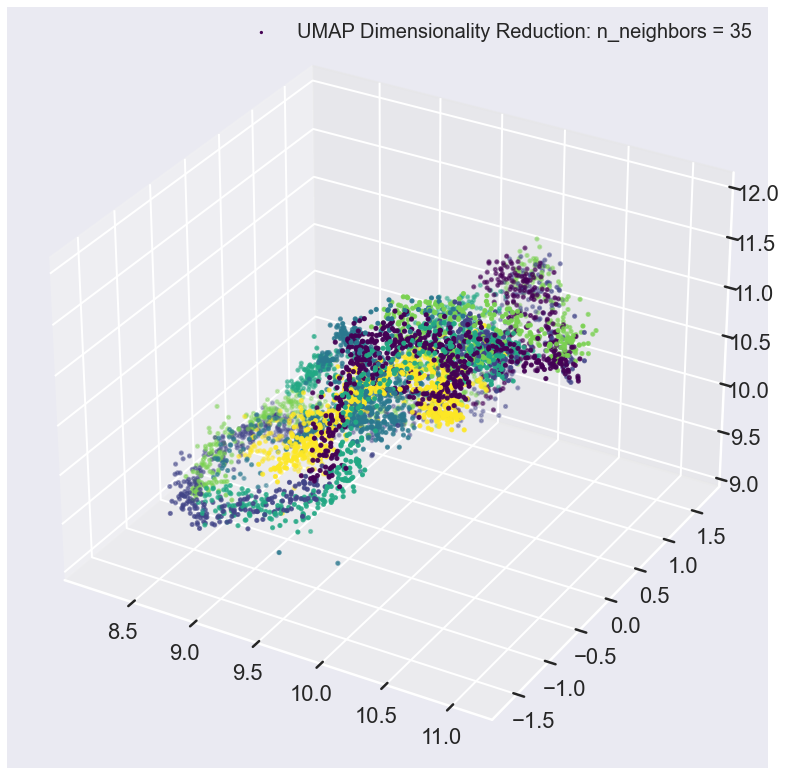

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.940962        0.941634     0.941473   
2                Random Forest       0.938776        0.939193     0.938963   
3               Decsision Tree       0.865889        0.867339     0.866933   
4                     AdaBoost       0.535714        0.539835     0.536664   
5         Gaussian Naive Bayes       0.491983        0.510037     0.493923   
1  Stochastic Gradient Descent       0.361516        0.391243     0.357202   
7          Logistic Regression       0.349854        0.313874     0.350942   
0                        Dummy       0.153061         0.02551     0.166667   

   f1_score  
6  0.941115  
2  0.938772  
3  0.866536  
4  0.528085  
5  0.481329  
1  0.329749  
7  0.329413  
0  0.044248  


C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res_b)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Result - performed best at n = 30

## Same process as before

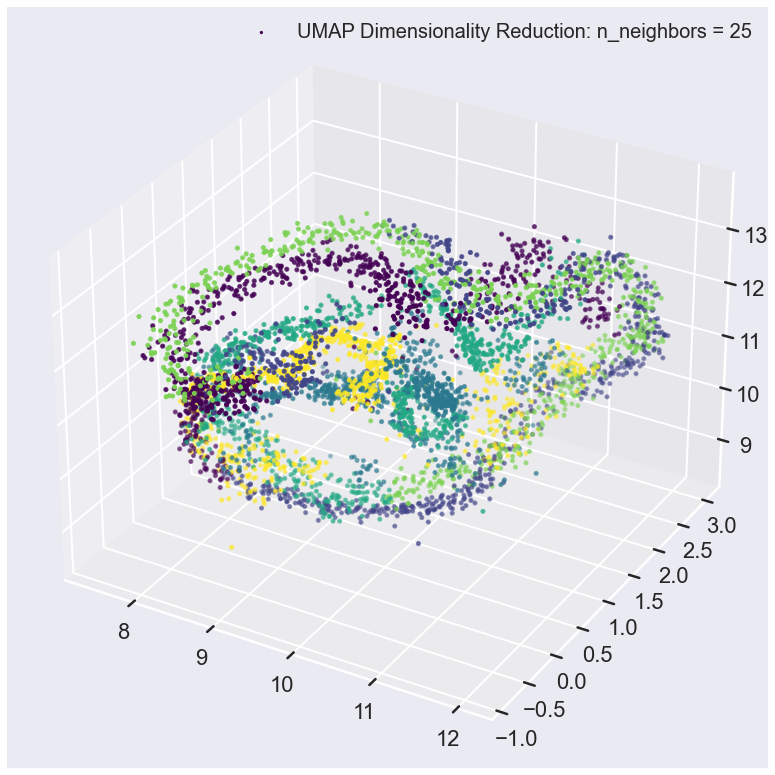

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,K Nearest Neighbor,0.822157,0.827841,0.823363,0.824578
0,Random Forest,0.821429,0.825389,0.823137,0.823013
1,Decsision Tree,0.758746,0.759901,0.760099,0.759458
2,AdaBoost,0.387026,0.452461,0.393896,0.385803


In [14]:
fit = umap.UMAP(n_neighbors = 30,
                min_dist = .1,
                n_components = 3,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res_b)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 25'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap, 
                                                    y_res_b, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train_b, y_train_b)
        y_pred = v.predict(X_test_b)
        ac_score_list.append(accuracy_score(y_test_b, y_pred))
        p_score_list.append(precision_score(y_test_b, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test_b, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test_b, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res_b, y_res_b)

In [ ]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=5,
                                      p =2,
                                      weights='distance')

In [ ]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res_b, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_c, y_train_c).predict_proba(X_test_c)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_c.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

In [ ]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_d, y_train_d)
y_pred = knn_best_model.predict(X_test_d)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_d, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_d, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


In [ ]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res_b)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout